In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
import numpy as np

/home/joe/ml/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Device agnostic code

Here we check if the cuda is available then we are going to set it on the device, otherwise we are going to use cpu.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Prepare the dataset

we should here parepare the dataset

In [3]:
# for reproduceability prepare the dataset
RANDOM_SEED = 42
SAMPLE_SIZE = 1000

# get the moons data
X, y = make_moons(SAMPLE_SIZE, random_state=RANDOM_SEED)

# we split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# print to ensure that the shapes matches and we properly made the split.
print("Shapes of data splited:\n", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# convert the numpy arrays to tensors and ensure the type is float32 because numpy defaults to float64
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

Shapes of data splited:
 (800, 2) (200, 2) (800,) (200,)


### Build the model

In [4]:
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = nn.Linear(2, 64)
    self.linear_2 = nn.Linear(64, 16)
    self.linear_3 = nn.Linear(16, 1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x)))))

In [5]:
model_v0 = MoonModelV0().to(device)

In [6]:
# initialize the optimizer and metrics
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
acc_fn = Accuracy(task='binary')

# build the training and testing loop
epochs = 500

for epoch in range(epochs):
  # build the training loop

  # set the model into the training mode
  model_v0.train()
  # do the forward pass
  y_logits = model_v0(X_train).squeeze()
  y_preds = torch.sigmoid(y_logits)
  # calculate the metrics
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_preds, y_train)
  # zero the optimizer gradients and step it
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # build the testing loop
  model_v0.eval()
  with torch.inference_mode():
    y_test_logits = model_v0(X_test).squeeze()
    y_test_preds = torch.sigmoid(y_test_logits)

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = acc_fn(y_test_preds, y_test)

  if epoch % 25 == 0:
    print(f"epoch: {epoch}, loss: {loss:0.4f}, acc: {acc * 100:0.2f} | test_loss: {test_loss:0.4f}, test_acc: {test_acc * 100:0.2f}")


epoch: 0, loss: 0.6981, acc: 50.00 | test_loss: 0.6921, test_acc: 50.00
epoch: 25, loss: 0.4941, acc: 82.38 | test_loss: 0.5022, test_acc: 81.00
epoch: 50, loss: 0.3199, acc: 84.88 | test_loss: 0.3348, test_acc: 85.50
epoch: 75, loss: 0.2596, acc: 87.38 | test_loss: 0.2687, test_acc: 87.50
epoch: 100, loss: 0.2294, acc: 88.75 | test_loss: 0.2336, test_acc: 90.50
epoch: 125, loss: 0.2094, acc: 90.25 | test_loss: 0.2107, test_acc: 90.50
epoch: 150, loss: 0.1936, acc: 91.00 | test_loss: 0.1932, test_acc: 91.50
epoch: 175, loss: 0.1790, acc: 91.75 | test_loss: 0.1776, test_acc: 92.50
epoch: 200, loss: 0.1644, acc: 92.50 | test_loss: 0.1623, test_acc: 93.00
epoch: 225, loss: 0.1494, acc: 93.50 | test_loss: 0.1468, test_acc: 93.00
epoch: 250, loss: 0.1341, acc: 94.25 | test_loss: 0.1313, test_acc: 94.50
epoch: 275, loss: 0.1186, acc: 95.00 | test_loss: 0.1158, test_acc: 95.50
epoch: 300, loss: 0.1035, acc: 95.62 | test_loss: 0.1008, test_acc: 97.00
epoch: 325, loss: 0.0893, acc: 96.62 | test

### Visualize the result

In [7]:
y_test_preds.round()

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])

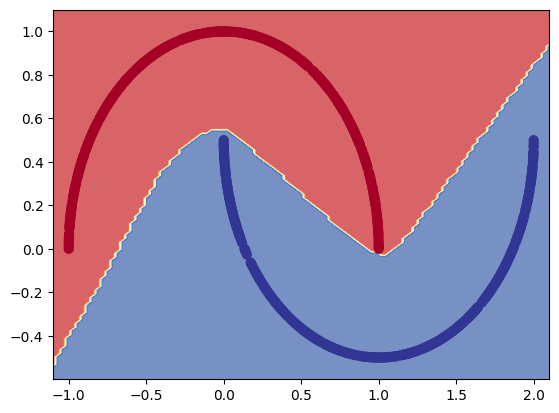

In [10]:
from utils.boundaries import plot_decision_boundary

plot_decision_boundary(model_v0, X_train, y_train)